In [57]:
%load_ext autoreload
%autoreload 2

import os
import sys

def insert_to_path(lib_dir):
    if lib_dir not in sys.path:
        sys.path.insert(0, lib_dir)
        
insert_to_path('code/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [188]:
import json

import h5py
import numpy as np
from PIL import Image

import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn

import matplotlib.pyplot as plt

from utils import IntermediateLayerGetter as MidGetter

In [288]:
np.concatenate([np.zeros((1, 5, 3)), np.ones((10, 5, 3))]).shape

(11, 5, 3)

In [449]:
import cv2
from itertools import zip_longest

def gen_img_with_boxes(img_or_img_fp, boxes, labels=[], scores=[], c=(255, 0, 255), linewidth=2):
    if type(img_or_img_fp) is str:
        img = np.array(Image.open(img_or_img_fp).convert('RGB'))
    else:
        img = np.array(img_or_img_fp)
    boxes = np.array(boxes).astype(np.int64)
    
    for box_coords, label, score in zip_longest(boxes, labels, scores):
        bbox = box_coords
        top_left = box_coords[:2].tolist()
        bottom_right = box_coords[2:].tolist()
        img = cv2.rectangle(img, tuple(top_left), tuple(bottom_right), c, linewidth)
        
        if label or score:
            if label and score:
                txt = '{}:{.2f}'.format(label, score)
            elif label:
                txt = label
            else:
                txt = f'{score:.2f}'
            font = cv2.FONT_HERSHEY_SIMPLEX
            cat_size = cv2.getTextSize(txt, font, 0.5, 2)[0]
    
            cv2.rectangle(img,
                            (bbox[0], bbox[1] - cat_size[1] - 2),
                            (bbox[0] + cat_size[0], bbox[1] - 2), c, -1)
            cv2.putText(img, txt, (bbox[0], bbox[1] - 2), 
                      font, 0.5, (255, 255, 255), thickness=1, lineType=cv2.LINE_AA)
        
    return img

def plot_img_with_boxes(img_fp, boxes, labels=[], scores=[]):
    img_with_boxes = gen_img_with_boxes(img_fp, boxes, labels=labels, scores=scores)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img_with_boxes)
    
    return fig, ax
    
def get_scene_objs(scene):
    scene_objs = {'labels': [], 'objects': []}
    objs = scene_objs['objects']
    labels = scene_objs['labels']
    for obj in scene['objects'].values():
        # objs.append((obj['x'], obj['y'], obj['x'] + obj['h'], obj['y'] + obj['w']))
        objs.append((obj['x'], obj['y'], obj['x'] + obj['w'], obj['y'] + obj['h']))
        labels.append(obj['name'])
    return scene_objs

In [487]:
detector = maskrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)
detector.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
         

In [488]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

return_layers = {
    'backbone': 'img_features',
    'rpn': 'proposals',
    'roi_heads.box_roi_pool': 'box_roi_pool',
    'roi_heads.box_head': 'box_features',
    'transform': 'transformed_images',
}

mid_getter = MidGetter(model=detector, return_layers=return_layers, keep_output=True)
mid_getter.eval();

roi_heads_return_layers = {
    'box_roi_pool': 'box_roi_pool',
    'box_head': 'box_features',
    'mask_roi_pool': 'mask_roi_pool',
    'mask_head': 'mask_features',
}

roi_heads_midg = MidGetter(model=detector.roi_heads, return_layers=roi_heads_return_layers, keep_output=True)
roi_heads_midg.eval();

In [222]:
imgs_dir = '/Users/sebamenabar/Documents/datasets/GQA/images/'
split = 'val'

with open(f'/Users/sebamenabar/Documents/datasets/GQA/sceneGraphs/{split}_sceneGraphs.json', 'r') as f:
    sgs = json.load(f)
    
data = h5py.File('/Users/sebamenabar/Documents/datasets/GQA/data/gqa_objects.h5')
features = data['features']
bboxes = data['bboxes']

image_ids = list(sgs.keys())

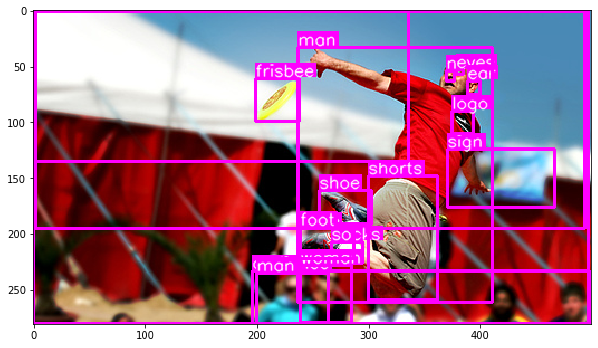

In [346]:
id_idx = 0
img_id = image_ids[id_idx]

img_fname = f'{img_id}.jpg'
img_fp = os.path.join(imgs_dir, img_fname)
img_scene = sgs[img_id]

img = Image.open(img_fp).convert('RGB')
img_num_boxes = img_info['objectsNum']
scene_objs = get_scene_objs(img_scene)

fig, ax = plot_img_with_boxes(img, scene_objs['objects'], labels=scene_objs['labels'])
ax.use_sticky_edges = False
ax.margins(tight=True)
plt.show()

In [465]:
timg = transform(img)
images = [timg]
mapping, labels = np.unique(scene_objs['labels'], return_inverse=True)
labels = torch.as_tensor(labels)
boxes = torch.as_tensor(scene_objs['objects'])[:, [1, 0, 3, 2]].to(torch.float32)
targets = [dict(boxes=boxes, labels=labels)]
original_image_sizes = [img.shape[-2:] for img in images]

with torch.no_grad():
    mid_outputs, output = mid_getter(images, targets)

In [489]:
transformed_images, transformed_targets = mid_outputs['transformed_images']
transformed_boxes = [img_targets['boxes'] for img_targets in transformed_targets]
transformed_image_sizes = transformed_images.image_sizes
proposals = mid_outputs['proposals']

In [490]:
with torch.no_grad():
    roi_heads_mid_outputs, roi_heads_output = roi_heads_midg(mid_outputs['img_features'], transformed_boxes, transformed_image_sizes)

In [491]:
roi_heads_mid_outputs['box_roi_pool'].size(), roi_heads_mid_outputs['box_features'].size(), roi_heads_mid_outputs['mask_roi_pool'].size(), roi_heads_mid_outputs['mask_features'].size()

(torch.Size([18, 256, 7, 7]),
 torch.Size([18, 1024]),
 torch.Size([4, 256, 14, 14]),
 torch.Size([4, 256, 14, 14]))

In [501]:
roi_heads_output[0][0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [502]:
roi_heads_output[0][0]['boxes'].size(), roi_heads_output[0][0]['masks'].size()

(torch.Size([4, 4]), torch.Size([4, 1, 28, 28]))

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x34a8d4790>)

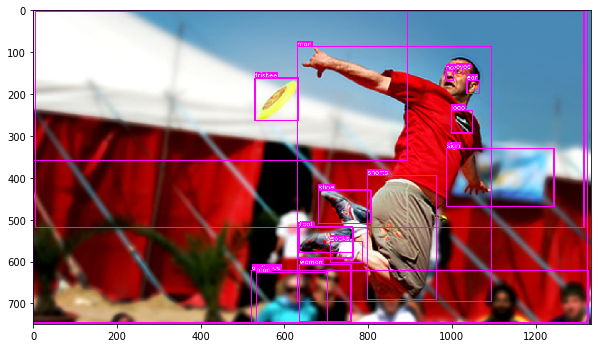

In [450]:
resized_img = Image.open(img_fp).convert('RGB')
resized_img = resized_img.resize(transformed_image_sizes[0][::-1], resample=Image.BILINEAR)
resized_img = np.array(resized_img)

plot_img_with_boxes(resized_img, transformed_targets[0]['boxes'][:, [1,0,3,2]], labels=scene_objs['labels'])

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x35e3f8c90>)

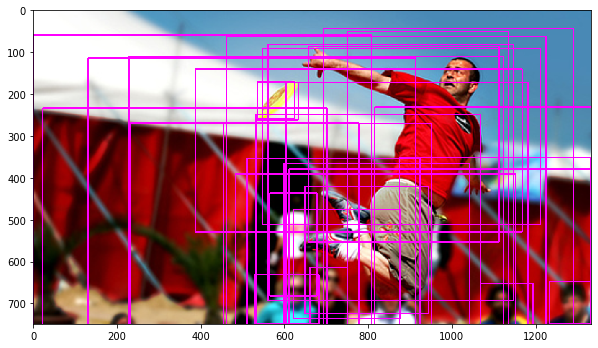

In [456]:
plot_img_with_boxes(resized_img, proposals[0][0][:30])

In [141]:
img_fp = '1.jpg'
img = Image.open(img_fp).convert('RGB')
timg = transform(img)

images = [timg]
original_image_sizes = [img.shape[-2:] for img in images]

with torch.no_grad():
    mid_outputs, output = mid_getter(images)
    
transformed_image_sizes = mid_outputs['transformed_images'][0].image_sizes # 0: ImageList, 1: Boxes

In [374]:
detector.training

False

In [ ]:
transformed_images

In [133]:
mid_outputs.keys()

odict_keys(['transformed_images', 'img_features', 'proposals', 'box_roi_pool', 'box_features'])

In [147]:
image_list = mid_outputs['transformed_images'][0]
image_list.tensors.size()

torch.Size([1, 3, 800, 1088])

In [177]:
image_list.image_sizes[0]

torch.Size([800, 1066])

In [185]:
c = (255, 0, 255)
linewidth = 2
labels = scores = []

img = Image.open(img_fp).convert('RGB')
img = img.resize(image_list.image_sizes[0][::-1], resample=Image.BILINEAR)
img = np.array(img)
boxes = mid_outputs['proposals'][0][0][:100].numpy()

for box_coords, label, score in zip_longest(boxes, labels, scores):
    top_left = box_coords[:2].astype(np.int64).tolist()
    bottom_right = box_coords[2:].astype(np.int64).tolist()
    img = cv2.rectangle(img, tuple(top_left), tuple(bottom_right), c, linewidth)

    # TODO add scores and labels in case include

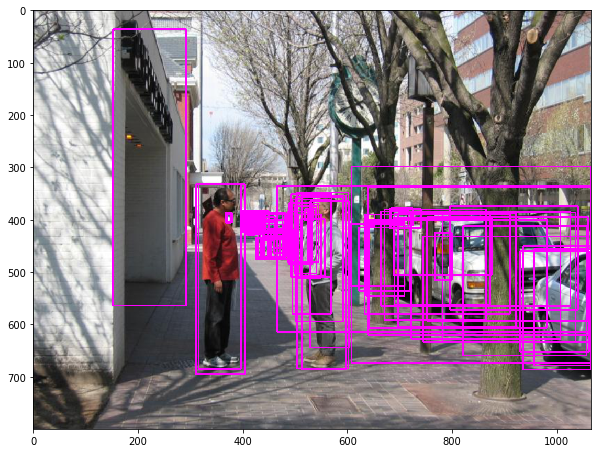

In [186]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img)
plt.show()

In [112]:
detections

[tensor([[ 957.3974,  456.7049, 1066.0000,  678.9401],
         [ 722.0975,  385.5392, 1007.4850,  628.0131],
         [ 430.4945,  426.4435,  482.5016,  474.1445],
         ...,
         [ 222.2015,   44.2712,  981.8251,  706.4564],
         [ 528.6857,    0.0000,  857.8357,  800.0000],
         [ 781.2513,  458.0969, 1008.4664,  691.8091]])]

In [122]:
mid_outputs['proposals'][0]

[tensor([[ 957.3974,  456.7049, 1066.0000,  678.9401],
         [ 722.0975,  385.5392, 1007.4850,  628.0131],
         [ 430.4945,  426.4435,  482.5016,  474.1445],
         ...,
         [ 222.2015,   44.2712,  981.8251,  706.4564],
         [ 528.6857,    0.0000,  857.8357,  800.0000],
         [ 781.2513,  458.0969, 1008.4664,  691.8091]])]

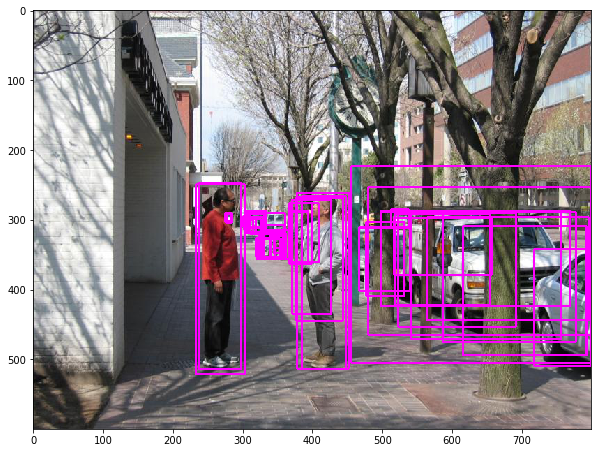

In [152]:
img_boxes = gen_img_with_boxes(img_fp, detections[0]['boxes'][:50].numpy())
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_boxes)
plt.show()

In [75]:
detector

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       